In [36]:
# On exécute pip install openpyxl dans le terminal
import pandas as pd
import sqlite3

def création_bdd():
    df1 = pd.read_csv('ValueCo Industrials Europe coverage.csv')
    df2 = pd.read_csv('Controversies Results Feb 24 2025.csv')
    df2_filtré = df2[df2['Client_ID'].isin(df1['isin'])]
    df3 = pd.read_excel('Controversy data documentation.xlsx')
    
    # On vérifie si la colonne 'Factor Column Header' existe dans le DataFrame filtré
    if not df3.empty:
        l_colonnes = df3['Factor Column Header'].tolist()
    else:
        print(f"Aucune ligne trouvée pour aucun type de score")
        return
    
    l_colonnes_complet = ["Client_ID"] + l_colonnes
    
    # On filtre df2 avec les colonnes nécessaires
    df2_filtréx2 = df2_filtré[l_colonnes_complet]
    df2_filled = df2_filtréx2.fillna(0)
    df2_filled = df2_filled.loc[:, ~(df2_filled == 0.0).all()]

    # On calcule les différences de score SI des entreprises entre janvier et mars
    df = pd.read_csv('BQ Results Apr 8 2025.csv')
    df['period'] = pd.to_datetime(df['period'], errors='coerce')
    
    df_filtré = df[df['score_kind'] == 'SI']
    
    start_date = pd.to_datetime('2024-12-01')
    end_date = pd.to_datetime('2025-02-01')
    
    df_filtré = df_filtré[df_filtré['period'].isin([start_date, end_date])]
    
    # Pivot pour avoir une colonne par date
    pivot = df_filtré.pivot(index='isin', columns='period', values='consensus')
    
    # Calcul de la différence
    pivot['Diff'] = pivot[end_date] - pivot[start_date]
    
    # On garde seulement la différence
    pivot = pivot[['Diff']].reset_index()

    # Harmonisation du nom de clé
    df2_filled  = df2_filled .rename(columns={'Client_ID': 'isin'})

    # Fusion des bases
    df_merged = pd.merge(df2_filled , pivot, on='isin')
    return df_merged



In [37]:
import pandas as pd
import statsmodels.api as sm

def reg_lin(df_merged):
    
    x=df_merged.drop(columns=['isin','Diff'])
    # Vérification que X n'est pas vide ou 100% NaN
    if x.dropna(how='all').empty:
        print("❌ Les variables explicatives sont vides ou entièrement nulles.")
        return

    x= sm.add_constant(x)

    y = df_merged['Diff']

    if y.isnull().all():
        print("❌ La variable dépendante 'Diff' est entièrement vide.")
        return

    # Régression linéaire
    model = sm.OLS(y, x).fit()
    print(model.summary())

In [38]:
reg_lin(création_bdd())

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.405
Date:                Fri, 09 May 2025   Prob (F-statistic):             0.0633
Time:                        14:59:04   Log-Likelihood:                 721.76
No. Observations:                 255   AIC:                            -1358.
Df Residuals:                     212   BIC:                            -1205.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [39]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reg_ridge_lasso(df_merged):

    X = df_merged.drop(columns=['isin', 'Diff'])
    y = df_merged['Diff']

    # Vérifications
    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    # Prétraitement : imputation et standardisation
    X = X.fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Ridge regression avec validation croisée
    ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5).fit(X_scaled, y)
    print("✅ Ridge Regression")
    print(f"Meilleur alpha : {ridge.alpha_}")
    print(f"Score R² : {ridge.score(X_scaled, y)}\n")

    # Lasso regression avec validation croisée
    lasso = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, max_iter=10000).fit(X_scaled, y)
    print("✅ Lasso Regression")
    print(f"Meilleur alpha : {lasso.alpha_}")
    print(f"Score R² : {lasso.score(X_scaled, y)}")

    # Optionnel : Affichage des coefficients non nuls (Lasso = sélection de variables)
    coef = pd.Series(lasso.coef_, index=X.columns)
    print("\nVariables sélectionnées par Lasso :")
    print(coef[coef != 0])

     # Visualisation des coefficients
    plt.figure(figsize=(12, 6))

    # Ridge coefficients
    ridge_coef = pd.Series(ridge.coef_, index=X.columns)
    ridge_coef.plot(kind='bar', color='skyblue', label='Ridge Coefficients', alpha=0.7)

    # Lasso coefficients
    lasso_coef = pd.Series(lasso.coef_, index=X.columns)
    lasso_coef.plot(kind='bar', color='salmon', label='Lasso Coefficients', alpha=0.7)

    plt.title("Comparaison des coefficients Ridge vs Lasso")
    plt.ylabel("Poids des variables")
    plt.xlabel("Variables explicatives")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Affichage de la performance
    print("\n✅ Visualisation des performances :")
    print(f"Ridge R² : {ridge.score(X_scaled, y):.4f}")
    print(f"Lasso R² : {lasso.score(X_scaled, y):.4f}")

    return ridge, lasso

✅ Ridge Regression
Meilleur alpha : 719.6856730011514
Score R² : 0.05266402656697944

✅ Lasso Regression
Meilleur alpha : 10000.0
Score R² : 0.0

Variables sélectionnées par Lasso :
Series([], dtype: float64)


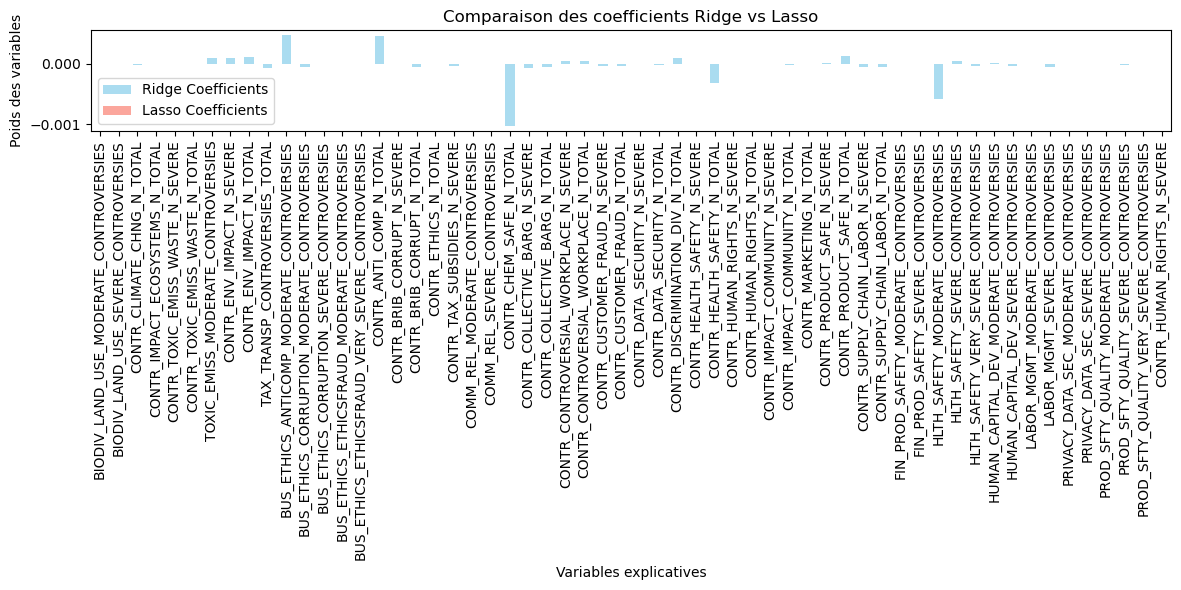


✅ Visualisation des performances :
Ridge R² : 0.0527
Lasso R² : 0.0000


(RidgeCV(alphas=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
        4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
        2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
        9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
        4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
        1.84206997e-01, 2.68269580e-0...
        8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
        3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
        1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
        7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
        3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
        1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
        6.86648845e+03, 1.00000000e+04]),
         cv=5),
 LassoCV(alphas=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       

In [40]:
reg_ridge_lasso(création_bdd())

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reg_random_forest(df):

    X = df.drop(columns=['isin', 'Diff'])
    y = df['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    X = X.fillna(0)

    # Optionnel : standardisation (pas obligatoire pour RF, mais utile pour homogénéiser)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Séparation pour valider les performances
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modèle Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    # Évaluation
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    cv_scores = cross_val_score(rf, X_scaled, y, cv=5)

    print("✅ Random Forest Regressor")
    print(f"R² entraînement : {train_score:.4f}")
    print(f"R² test : {test_score:.4f}")
    print(f"R² validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Importances des variables
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette='viridis')
    plt.title("Importance des variables (Random Forest)")
    plt.xlabel("Importance relative")
    plt.tight_layout()
    plt.show()

    return rf

✅ Random Forest Regressor
R² entraînement : 0.2131
R² test : 0.0850
R² validation croisée : -0.2460 ± 0.2671


/tmp/ipykernel_177086/466697625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


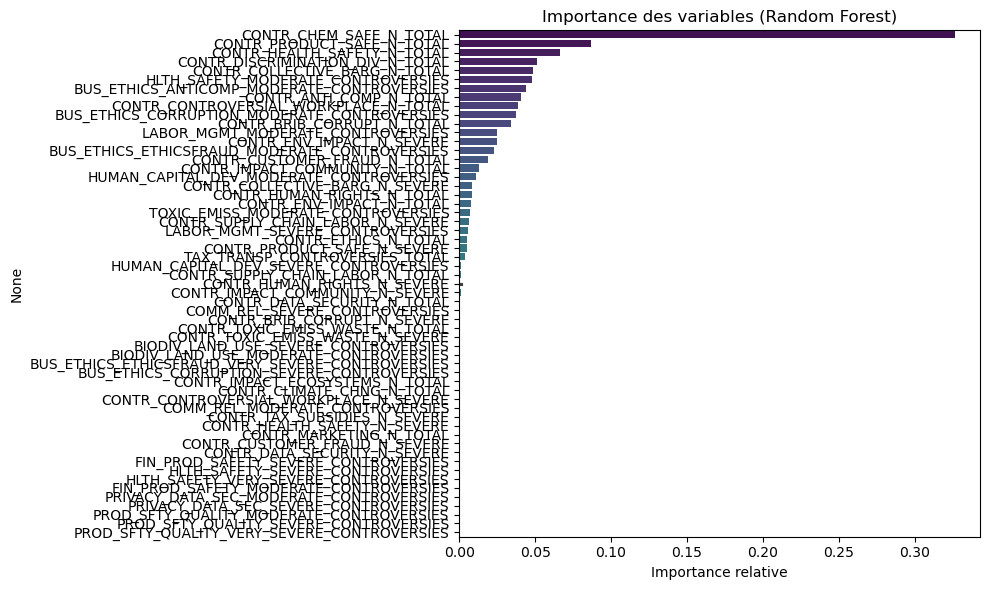

RandomForestRegressor(max_depth=5, random_state=42)

In [42]:
reg_random_forest(création_bdd())

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

def reg_gradient_boosting(df_merged):

    X = df_merged.drop(columns=['isin', 'Diff']).fillna(0)
    y = df_merged['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes.")
        return

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split pour évaluation
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Gradient Boosting
    gb=GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
    gb.fit(X_train, y_train)

    # Évaluations
    r2_train = gb.score(X_train, y_train)
    r2_test = gb.score(X_test, y_test)
    cv_scores = cross_val_score(gb, X_scaled, y, cv=5, scoring='r2')

    print("✅ Gradient Boosting Regressor")
    print(f"R² entraînement : {r2_train:.4f}")
    print(f"R² test : {r2_test:.4f}")
    print(f"R² validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Variables importantes
    importances = pd.Series(gb.feature_importances_, index=df_merged.drop(columns=['isin', 'Diff']).columns)
    importances = importances.sort_values(ascending=False)

    print("\n📌 Top variables importantes :")
    print(importances.head(10))

    return gb, importances

In [44]:
reg_gradient_boosting(création_bdd())

✅ Gradient Boosting Regressor
R² entraînement : 0.2168
R² test : -0.0031
R² validation croisée : -0.2243 ± 0.2408

📌 Top variables importantes :
CONTR_CHEM_SAFE_N_TOTAL                          0.463849
CONTR_HEALTH_SAFETY_N_TOTAL                      0.083623
HLTH_SAFETY_MODERATE_CONTROVERSIES               0.074314
CONTR_DISCRIMINATION_DIV_N_TOTAL                 0.062272
CONTR_PRODUCT_SAFE_N_SEVERE                      0.054989
BUS_ETHICS_ETHICSFRAUD_MODERATE_CONTROVERSIES    0.051884
CONTR_CONTROVERSIAL_WORKPLACE_N_TOTAL            0.042544
TOXIC_EMISS_MODERATE_CONTROVERSIES               0.033454
HUMAN_CAPITAL_DEV_MODERATE_CONTROVERSIES         0.031265
BUS_ETHICS_ANTICOMP_MODERATE_CONTROVERSIES       0.028568
dtype: float64


(GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50),
 CONTR_CHEM_SAFE_N_TOTAL                             0.463849
 CONTR_HEALTH_SAFETY_N_TOTAL                         0.083623
 HLTH_SAFETY_MODERATE_CONTROVERSIES                  0.074314
 CONTR_DISCRIMINATION_DIV_N_TOTAL                    0.062272
 CONTR_PRODUCT_SAFE_N_SEVERE                         0.054989
 BUS_ETHICS_ETHICSFRAUD_MODERATE_CONTROVERSIES       0.051884
 CONTR_CONTROVERSIAL_WORKPLACE_N_TOTAL               0.042544
 TOXIC_EMISS_MODERATE_CONTROVERSIES                  0.033454
 HUMAN_CAPITAL_DEV_MODERATE_CONTROVERSIES            0.031265
 BUS_ETHICS_ANTICOMP_MODERATE_CONTROVERSIES          0.028568
 LABOR_MGMT_MODERATE_CONTROVERSIES                   0.021618
 CONTR_ETHICS_N_TOTAL                                0.018638
 CONTR_ENV_IMPACT_N_SEVERE                           0.018446
 CONTR_PRODUCT_SAFE_N_TOTAL                          0.012967
 CONTR_ENV_IMPACT_N_TOTAL                            0